In [1]:
!git branch

  1-dataframe
  19-machine-tagger
  3-group-senses
  4-semantic-provenance
* 44-kNN-BERT-baseline
  dev
  master
  oed-experiments


In [102]:
%matplotlib inline
import pandas as pd
import numpy as np
import flair
from flair.data import Sentence
from utils.classificaton_utils import *
from flair.embeddings import TransformerWordEmbeddings
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report,accuracy_score
from tqdm.notebook import tqdm

In [118]:
embedding_type = TransformerWordEmbeddings('bert-base-uncased',
                                           layers='-1,-2,-3,-4',
                                           pooling_operation='mean')

In [119]:
quotations_df = pd.read_pickle('./data/quotations_all_machine_nn01.pickle')
quotations_df.head()

,id,text,year,lemma,source,oed_url,word_id,sense_id,datestring,first_in_word,oed_reference,first_in_sense
0,pigmeat_nn01-13163366,"{'keyword': 'pig-meat', 'full_text': 'I was at...",1754,pigmeat,"{'title': 'Connoisseur', 'author': 'G. Colman'...",https://www.oed.com/view/Entry/237320#eid13163366,pigmeat_nn01,pigmeat_nn01-13163363,1754,True,"pigmeat, n., sense 1",True
1,pigmeat_nn01-13163379,"{'keyword': 'pig-meat', 'full_text': 'In short...",1784,pigmeat,"{'title': 'Year's Journey through Paix Bâs', '...",https://www.oed.com/view/Entry/237320#eid13163379,pigmeat_nn01,pigmeat_nn01-13163363,1784,False,"pigmeat, n., sense 1",False
2,pigmeat_nn01-13163399,"{'keyword': 'pig meat', 'full_text': 'It preve...",1817,pigmeat,"{'title': 'Parl. Deb.', 'author': None, 'gende...",https://www.oed.com/view/Entry/237320#eid13163399,pigmeat_nn01,pigmeat_nn01-13163363,1817,False,"pigmeat, n., sense 1",False
3,pigmeat_nn01-13163416,"{'keyword': 'pig meat', 'full_text': 'In most ...",1897,pigmeat,"{'title': 'Syst. Med.', 'author': 'T. C. Allbu...",https://www.oed.com/view/Entry/237320#eid13163416,pigmeat_nn01,pigmeat_nn01-13163363,1897,False,"pigmeat, n., sense 1",False
4,pigmeat_nn01-13163425,"{'keyword': 'pig meat', 'full_text': 'Beef tak...",1918,pigmeat,"{'title': 'Times', 'author': None, 'gender': N...",https://www.oed.com/view/Entry/237320#eid13163425,pigmeat_nn01,pigmeat_nn01-13163363,1918,False,"pigmeat, n., sense 1",False


## Run Code

In [120]:
selected_quotations = filter_quotations_by_year(quotations_df,1760,1920)
selected_quotations.shape

(69843, 9)

In [121]:
selected_quotations.head()

,keyword,full_text,keyword_offset,title,author,gender,year,sense_id,word_id
1,pig-meat,"In short, (pig-meat excepted) he is a dealer i...",11.0,Year's Journey through Paix Bâs,P. Thicknesse,male,1784,pigmeat_nn01-13163363,pigmeat_nn01
2,pig meat,"It prevented the preservation of meat, and esp...",57.0,Parl. Deb.,None,None,1817,pigmeat_nn01-13163363,pigmeat_nn01
3,pig meat,In most cases the infected food has been pig m...,41.0,Syst. Med.,T. C. Allbutt,male,1897,pigmeat_nn01-13163363,pigmeat_nn01
4,pig meat,"Beef takes a long time to grow, while pig meat...",38.0,Times,None,None,1918,pigmeat_nn01-13163363,pigmeat_nn01
47,Charley,"Charley, a watchman, Charley-ken, a watch-box.",0.0,New Vocab. Flash Lang.,J. H. Vaux,male,1819,charley_nn01-9609483,charley_nn01


In [133]:
selected_quotations.word_id.value_counts()[:10]

head_nn01      359
run_nn02       325
line_nn02      278
way_nn01       268
runner_nn01    245
stock_nn01     243
point_nn01     236
fall_nn02      210
lay_vb01       206
ring_nn01      197
Name: word_id, dtype: int64

In [173]:
lemma_id = 'head_nn01'
quotations_by_lemma = selected_quotations[selected_quotations.word_id==lemma_id]
quotations_by_lemma.shape

(359, 9)

In [174]:
quotations_by_lemma['vector'] = quotations_by_lemma.apply(get_target_token_vector,
                                    embedding_type=embedding_type,
                                    axis=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [175]:
quotations_by_lemma.sense_id.value_counts().to_dict()

{'head_nn01-1839048': 6,
 'head_nn01-1835150': 6,
 'head_nn01-1838095': 6,
 'head_nn01-1839099': 5,
 'head_nn01-1838871': 5,
 'head_nn01-1836535': 5,
 'head_nn01-1837511': 5,
 'head_nn01-1836359': 5,
 'head_nn01-1835428': 5,
 'head_nn01-1839654': 5,
 'head_nn01-1835757': 5,
 'head_nn01-1836525': 5,
 'head_nn01-290715664': 5,
 'head_nn01-1838752': 4,
 'head_nn01-278255054': 4,
 'head_nn01-1839425': 4,
 'head_nn01-1837548': 4,
 'head_nn01-1839898': 4,
 'head_nn01-1839338': 4,
 'head_nn01-1839492': 4,
 'head_nn01-1836497': 4,
 'head_nn01-278546137': 4,
 'head_nn01-1836300': 4,
 'head_nn01-285147122': 4,
 'head_nn01-1838461': 4,
 'head_nn01-285147119': 4,
 'head_nn01-1835624': 4,
 'head_nn01-1837465': 4,
 'head_nn01-1838505': 4,
 'head_nn01-300253856': 4,
 'head_nn01-291351168': 4,
 'head_nn01-1835891': 4,
 'head_nn01-1835261': 4,
 'head_nn01-1837802': 4,
 'head_nn01-1836516': 4,
 'head_nn01-1838316': 4,
 'head_nn01-1836566': 4,
 'head_nn01-1838591': 4,
 'head_nn01-1839182': 4,
 'head_nn01

In [176]:
cosine_similiarity = lambda x, target : 1 - cosine(x,target)

def get_accuracy(train,test):
    y_true, y_pred, y_maj = [], [], []
    
    for i, row in test.iterrows():
        similarities = train.apply(cosine_similiarity,target = row.vector)
        
        y_pred.append(np.argmax(similarities))
        y_true.append(row.sense_id)
        y_maj.append('head_nn01-1839048')
    
    return accuracy_score(y_true,y_pred),accuracy_score(y_true,y_maj)

def evaluate(df):
    df = df.sample(frac=1.0).reset_index(drop=True)
    train,test = df.iloc[:-10],df.iloc[-10:]
    train = train.groupby('sense_id')['vector'].apply(np.mean,axis=0)
    return get_accuracy(train,test)

accs = [evaluate(quotations_by_lemma) for _ in tqdm(range(1000))]


/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


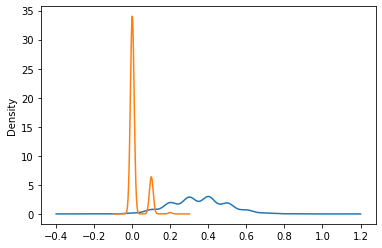

In [177]:
pd.Series([i for i,j in accs]).plot(kind='density')
pd.Series([j for i,j in accs]).plot(kind='density')

# Distinguish between machine sense of word

## Inspect code

In [5]:
def filter_quotations_by_year(
                      df_quotations:  pd.DataFrame,
                      start:int,
                      end: int
                    ) -> pd.DataFrame:
    """Create a dataframe with quotations and their metadata for 
    for a specific year range
    
    Arguments:
        df_quotations: dataframe with quotations, created using harvest_quotations_by_sense_id
        start (int): start year
        end (int):end year
        
    Returns:
        pd.DataFrame with quotations
        
    """
    df = pd.concat([
        pd.DataFrame.from_records(df_quotations.text.values),
        pd.DataFrame.from_records(df_quotations.source.values)
            ], axis=1)
    df['year'] = df_quotations['year']
    df['sense_id'] = df_quotations['sense_id']
    df['word_id'] = df_quotations['word_id']
    #df = df[df.sense_id.isin(senses)]
    df = df[(start <= df.year) & (df.year <= end)]
    
    df.drop_duplicates(inplace=True)
    
    return df

In [ ]:
selected_quotations = filter_quotations_by_year(quotations_df,1760,1920)
selected_quotations.shape

In [ ]:

def get_target_token_vector(row: pd.Series, 
                            embedding_type: TransformerWordEmbeddings,
                            punctuation: str = '!"#—$%&\()*+,./:;\'\—-<=>?@[\\]^_`{|}~‘’'):
    """
    Get a vector representation for a target expression in context.
    If the target expression consists of multiple words we average the 
    multiple vector representations.
    
    Arguments:
        row (pd.Series): a row from a quotations dataframe created by 
                        the function filter_quotations_by_year
    Returns:
        a np.array that captures the last layer(s) of the transformer
    """
    # replace all punctuation with white spaces
    text = ''.join([' ' if c in punctuation else c  for c in row.full_text.lower()])
    
    # if there is no quotation return None
    if text is '':
        return None
    
    text = Sentence(text,use_tokenizer=False)
    target = row.keyword # the offset as recorded by the OED
    vectors = []; quotation_target_tokens = [] # we collect the target tokens collected in the quotation
                                               # and match those with the target expression as a check (see below)
    
    # if there is no target word return none
    # remove punctuation from target expression
    if target is not None:
        target = ''.join([' ' if c in punctuation else c  for c in target.lower()])
    else:
        return None
    
    # get offsets of the target expression in the quotations
    start_position = row.keyword_offset
    end_position = start_position + len(target)
    
    # embedd text
    embedding_type.embed(text)
    
    for token in text:
        # here we rely on the FLAIR offset annotation in combination with tokenisation
        # double check if this works properly
        if (token.start_pos >= start_position) and (token.start_pos < end_position):
            vectors.append(token.embedding.numpy())
            quotation_target_tokens.append(token.text)
    if vectors:
        if ' '.join(quotation_target_tokens) != ' '.join(target.split()):
            print('Warning: could not properly match',' '.join(target.split()), ' with ',' '.join(quotation_target_tokens))
        
        return np.mean(vectors, axis=0)
    
    return None


In [ ]:
selected_quotations.apply(get_target_token_vector,
                                    embedding_type=embedding_type,
                                    axis=1)

## Fin.

In [ ]:
# X = [v.reshape(-1) for v in quot_sel.vector if v is not None]
# senses = [color_codes[s] for s,v in zip(quot_sel.sense_id,quot_sel.vector) if v is not None]
# #

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# fig = plt.figure(figsize = (10,10))

# tsne = TSNE(n_components=2, random_state=0,metric='cosine')
# X_2d = tsne.fit_transform(X)

# for i,x in enumerate(X):

#     plt.scatter(X_2d[i, 0], X_2d[i, 1],c=senses[i]) 
    
# plt.show()